In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0


In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
OP_DICT = ['zscore', 'cbrt', 'sigmoid', 'stdscaler','freq']

In [4]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def create_f1():
    def f1_function(y_true, y_pred):
        y_pred_binary = tf.where(y_pred>=0.5, 1., 0.)
        y_true = tf.cast(y_true, dtype=tf.float32)
        tp = tf.reduce_sum(y_true * y_pred_binary)
        predicted_positives = tf.reduce_sum(y_pred_binary)
        possible_positives = tf.reduce_sum(y_true)
        return tp, predicted_positives, possible_positives
    return f1_function
class F1_score(keras.metrics.Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.f1_function = create_f1()
        self.tp_count = self.add_weight("tp_count", initializer="zeros")
        self.all_predicted_positives = self.add_weight('all_predicted_positives', initializer='zeros')
        self.all_possible_positives = self.add_weight('all_possible_positives', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        tp, predicted_positives, possible_positives = self.f1_function(y_true, y_pred)
        self.tp_count.assign_add(tp)
        self.all_predicted_positives.assign_add(predicted_positives)
        self.all_possible_positives.assign_add(possible_positives)
    def result(self):
        precision = self.tp_count / self.all_predicted_positives
        recall = self.tp_count / self.all_possible_positives
        f1 = 2*(precision*recall)/(precision+recall)
        return f1

In [5]:
baseline_net = keras.Sequential([
            layers.Dense(450, activation='relu', input_shape=(400,)),
            layers.Dense(2, activation='softmax')
                ])
baseline_net.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
baseline_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 450)               180450    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 902       
Total params: 181,352
Trainable params: 181,352
Non-trainable params: 0
_________________________________________________________________


In [6]:
train_param = {
    'name': 'baseline',
    'data_dir': r"D:\!DTStack\Savefile_remote",
    'train_name':'basline_f1_score',
    'operator':OP_DICT,
    'model':baseline_net,
    'if_balanced':True,
    'balance_percent':0.4,
}

In [7]:
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.callbacks import Callback

class Metrics(Callback):
  def __init__(self, val_data, val_label):
      super(Callback, self).__init__()
      self.val_data = val_data
      self.val_label = val_label
  def on_train_begin(self, logs={}):
    self.val_f1s = []
  def on_epoch_end(self, epoch, logs={}):
    val_predict=(np.asarray(self.model.predict_classes(self.val_data,batch_size=1))).round()
    val_targ = self.val_label
    _val_f1 = f1_score(val_targ, val_predict, average='binary')
    self.val_f1s.append(_val_f1)
    print("— val_f1: %f " % _val_f1)
    return

Using TensorFlow backend.


In [8]:
class LFE_learner():
    
    def __init__(self,param):
        self.name = param['name']
        self.train_name = param['train_name']
        self.data_dir = param['data_dir']
        self.operator = param['operator']
        self.model = param['model']
        self.data_dir = os.path.join(self.data_dir, 'dataset', self.name)
        self.save_dir = os.path.join(self.data_dir, 'savefile', self.train_name)
        
        self.if_balanced = param['if_balanced']
        self.balance_percent = param['balance_percent']
        
    
    def train_forward(self,hyprprm = None):
        from keras.callbacks import TensorBoard
        from keras.callbacks import ModelCheckpoint
        import matplotlib.pyplot as plt
        
        for oprtr in self.operator:
            
            data_path = os.path.join(self.data_dir, oprtr, 'data.csv')
            data = self.load_data(data_path)
            
            x_train, x_test, y_train, y_test = self.split_data(data, test_size=0.2)

            model = self.init_network()
            
            tensorboard = tf.keras.callbacks.TensorBoard( log_dir = os.path.join(self.save_dir,oprtr,'log') )
            
            checkpoint = ModelCheckpoint(filepath=os.path.join(self.save_dir,oprtr,
                                                               "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"),
                                         monitor='val_accuracy',
                                         mode='auto',
                                         save_best_only=False,
                                         period = 50,
                                        )
            
            __metrics = Metrics(x_test,y_test)
            callback_lists=[tensorboard,checkpoint,__metrics]
        
            history = model.fit(x_train, y_train, 
                                batch_size=4, epochs=500, 
                                validation_data = (x_test,y_test),
                                verbose=1,
                                callbacks=callback_lists)
            
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.plot(__metrics.val_f1s)
            plt.legend(['training', 'validation','val_f1'], loc='lower left')
            plt.savefig(r'{}\{}.png'.format(self.save_dir,oprtr))
            plt.show()
            
            
    
    def split_data(self,data,test_size=0.2):
        from sklearn.model_selection import train_test_split
        x_train, x_test, y_train, y_test = train_test_split(data[:,0:-1], data[:,-1], 
                                                            test_size=test_size, 
                                                            stratify = data[:,-1],
                                                            random_state=99)
        
        train_set = np.concatenate((x_train,y_train.reshape(-1,1)),axis = 1)
            
        if self.if_balanced:
            train_set = self.banlance_data(train_set,self.balance_percent)
            
        np.random.shuffle(train_set)
        
        return train_set[:,0:-1], x_test, train_set[:,-1], y_test
    
    
    
    def val_model(self,model_path ,oprtr ,if_pos = True):
        from keras.models import load_model
               
        data_path = os.path.join(self.data_dir, oprtr, 'data.csv')
        data = self.load_data(data_path)      
        
        x_train, x_test, y_train, y_test = self.split_data(data, test_size=0.2)
        
        if if_pos:
            x_test = pd.DataFrame (x_test)
            y_test = pd.DataFrame (y_test)
            idx = y_test.loc[y_test.iloc[:,-1]==1].index
            x_test = np.array(x_test.loc[idx] )
            y_test = np.array(y_test.loc[idx] )        


        
        model = tf.keras.models.load_model (model_path)
        
        return model.evaluate(x_test,y_test, batch_size = 4)
            
    
    def banlance_data(self,data,perc):
        df = pd.DataFrame(data)
        
        pos_data = df.loc[df.iloc[:,-1]==1]
        pos_num = len(pos_data)
        total_num = len(df)
        
        oversample_num = int(  ( perc*total_num - (1.0+perc)*pos_num )/(1-perc)  )
        df = pd.concat([df,pos_data.sample(n=oversample_num,replace=True,axis=0)],axis =0)
        
        return np.array(df)
        
    def init_network(self):
        return self.model
    
        
    def load_data(self,path):
        return np.array(pd.read_csv(path,header=None))
        
    

In [9]:
lqf = LFE_learner(train_param)

In [10]:
df = lqf.train_forward()

Train on 1898 samples, validate on 331 samples
Epoch 1/500
1898/1898 [==============================] - 2s 923us/sample - loss: 0.6456 - accuracy: 0.6307 - val_loss: 0.4521 - val_accuracy: 0.8912
Epoch 2/500
1898/1898 [==============================] - 1s 559us/sample - loss: 0.5950 - accuracy: 0.6723 - val_loss: 0.5327 - val_accuracy: 0.8550
Epoch 3/500
1898/1898 [==============================] - 1s 568us/sample - loss: 0.5444 - accuracy: 0.7144 - val_loss: 0.4759 - val_accuracy: 0.8550
Epoch 4/500
1898/1898 [==============================] - 1s 571us/sample - loss: 0.4952 - accuracy: 0.7566 - val_loss: 0.6435 - val_accuracy: 0.7311
Epoch 5/500
1898/1898 [==============================] - 1s 562us/sample - loss: 0.4548 - accuracy: 0.7861 - val_loss: 0.5437 - val_accuracy: 0.8550
Epoch 6/500
1898/1898 [==============================] - 1s 554us/sample - loss: 0.4153 - accuracy: 0.8066 - val_loss: 0.6104 - val_accuracy: 0.8006
Epoch 7/500
1898/1898 [==============================] - 1s

Epoch 33/500
1898/1898 [==============================] - 1s 526us/sample - loss: 0.2222 - accuracy: 0.9241 - val_loss: 0.8844 - val_accuracy: 0.8399
Epoch 34/500
1898/1898 [==============================] - 1s 569us/sample - loss: 0.2193 - accuracy: 0.9247 - val_loss: 0.9279 - val_accuracy: 0.8157
Epoch 35/500
1898/1898 [==============================] - 1s 527us/sample - loss: 0.2149 - accuracy: 0.9241 - val_loss: 0.9168 - val_accuracy: 0.8308
Epoch 36/500
1898/1898 [==============================] - 1s 547us/sample - loss: 0.2153 - accuracy: 0.9241 - val_loss: 0.8870 - val_accuracy: 0.8248
Epoch 37/500
1898/1898 [==============================] - 1s 513us/sample - loss: 0.2159 - accuracy: 0.9252 - val_loss: 0.9225 - val_accuracy: 0.8429
Epoch 38/500
1898/1898 [==============================] - 1s 569us/sample - loss: 0.2190 - accuracy: 0.9220 - val_loss: 0.8959 - val_accuracy: 0.8399
Epoch 39/500
1898/1898 [==============================] - 1s 593us/sample - loss: 0.2120 - accuracy:

1898/1898 [==============================] - 1s 528us/sample - loss: 0.1990 - accuracy: 0.9341 - val_loss: 0.9551 - val_accuracy: 0.8369
Epoch 66/500
1898/1898 [==============================] - 1s 500us/sample - loss: 0.1996 - accuracy: 0.9320 - val_loss: 0.9816 - val_accuracy: 0.8369
Epoch 67/500
1898/1898 [==============================] - 1s 509us/sample - loss: 0.1964 - accuracy: 0.9368 - val_loss: 0.9685 - val_accuracy: 0.8429
Epoch 68/500
1898/1898 [==============================] - 1s 503us/sample - loss: 0.1977 - accuracy: 0.9331 - val_loss: 0.9648 - val_accuracy: 0.8429
Epoch 69/500
1898/1898 [==============================] - 1s 517us/sample - loss: 0.2007 - accuracy: 0.9320 - val_loss: 1.0058 - val_accuracy: 0.8429
Epoch 70/500
1898/1898 [==============================] - 1s 500us/sample - loss: 0.1981 - accuracy: 0.9289 - val_loss: 0.9855 - val_accuracy: 0.8429
Epoch 71/500
1898/1898 [==============================] - 1s 507us/sample - loss: 0.1964 - accuracy: 0.9357 - val

1898/1898 [==============================] - 1s 594us/sample - loss: 0.1885 - accuracy: 0.9373 - val_loss: 1.0464 - val_accuracy: 0.8369
Epoch 98/500
1898/1898 [==============================] - 1s 600us/sample - loss: 0.1875 - accuracy: 0.9378 - val_loss: 1.0423 - val_accuracy: 0.8369
Epoch 99/500
1898/1898 [==============================] - 1s 553us/sample - loss: 0.1932 - accuracy: 0.9389 - val_loss: 1.0215 - val_accuracy: 0.8369
Epoch 100/500
1898/1898 [==============================] - 1s 544us/sample - loss: 0.1934 - accuracy: 0.9362 - val_loss: 1.0586 - val_accuracy: 0.8429
Epoch 101/500
1898/1898 [==============================] - 1s 529us/sample - loss: 0.1907 - accuracy: 0.9399 - val_loss: 1.0523 - val_accuracy: 0.8369
Epoch 102/500
1898/1898 [==============================] - 1s 530us/sample - loss: 0.1905 - accuracy: 0.9378 - val_loss: 1.0817 - val_accuracy: 0.8429
Epoch 103/500
1898/1898 [==============================] - 1s 533us/sample - loss: 0.1929 - accuracy: 0.9357 -

Epoch 129/500
1898/1898 [==============================] - 1s 524us/sample - loss: 0.1877 - accuracy: 0.9378 - val_loss: 1.0923 - val_accuracy: 0.8429
Epoch 130/500
1898/1898 [==============================] - 1s 550us/sample - loss: 0.1826 - accuracy: 0.9394 - val_loss: 1.1188 - val_accuracy: 0.8429
Epoch 131/500
1898/1898 [==============================] - 1s 597us/sample - loss: 0.1844 - accuracy: 0.9384 - val_loss: 1.1487 - val_accuracy: 0.8429
Epoch 132/500
1898/1898 [==============================] - 1s 574us/sample - loss: 0.1871 - accuracy: 0.9394 - val_loss: 1.1373 - val_accuracy: 0.8429
Epoch 133/500
1898/1898 [==============================] - 1s 573us/sample - loss: 0.1836 - accuracy: 0.9410 - val_loss: 1.1750 - val_accuracy: 0.8429
Epoch 134/500
1898/1898 [==============================] - 1s 532us/sample - loss: 0.1863 - accuracy: 0.9378 - val_loss: 1.1165 - val_accuracy: 0.8429
Epoch 135/500
1898/1898 [==============================] - 1s 550us/sample - loss: 0.1830 - ac

Epoch 161/500
1898/1898 [==============================] - 1s 546us/sample - loss: 0.1818 - accuracy: 0.9357 - val_loss: 1.2060 - val_accuracy: 0.8429
Epoch 162/500
1898/1898 [==============================] - 1s 519us/sample - loss: 0.1825 - accuracy: 0.9405 - val_loss: 1.2192 - val_accuracy: 0.8429
Epoch 163/500
1898/1898 [==============================] - 1s 555us/sample - loss: 0.1813 - accuracy: 0.9384 - val_loss: 1.2115 - val_accuracy: 0.8369
Epoch 164/500
1898/1898 [==============================] - 1s 560us/sample - loss: 0.1824 - accuracy: 0.9399 - val_loss: 1.2097 - val_accuracy: 0.8429
Epoch 165/500
1898/1898 [==============================] - 1s 579us/sample - loss: 0.1784 - accuracy: 0.9399 - val_loss: 1.2295 - val_accuracy: 0.8429
Epoch 166/500
1898/1898 [==============================] - 1s 716us/sample - loss: 0.1837 - accuracy: 0.9389 - val_loss: 1.2388 - val_accuracy: 0.8429
Epoch 167/500
1898/1898 [==============================] - 1s 575us/sample - loss: 0.1801 - ac

Epoch 193/500
1898/1898 [==============================] - 1s 512us/sample - loss: 0.1791 - accuracy: 0.9410 - val_loss: 1.2544 - val_accuracy: 0.8429
Epoch 194/500
1898/1898 [==============================] - 1s 507us/sample - loss: 0.1799 - accuracy: 0.9405 - val_loss: 1.3135 - val_accuracy: 0.8429
Epoch 195/500
1898/1898 [==============================] - 1s 506us/sample - loss: 0.1788 - accuracy: 0.9405 - val_loss: 1.3019 - val_accuracy: 0.8429
Epoch 196/500
1898/1898 [==============================] - 1s 557us/sample - loss: 0.1833 - accuracy: 0.9357 - val_loss: 1.2921 - val_accuracy: 0.8429
Epoch 197/500
1898/1898 [==============================] - 1s 532us/sample - loss: 0.1791 - accuracy: 0.9394 - val_loss: 1.2802 - val_accuracy: 0.8429
Epoch 198/500
1898/1898 [==============================] - 1s 531us/sample - loss: 0.1790 - accuracy: 0.9394 - val_loss: 1.2963 - val_accuracy: 0.8429
Epoch 199/500
1898/1898 [==============================] - 1s 529us/sample - loss: 0.1746 - ac

Epoch 225/500
1898/1898 [==============================] - 1s 500us/sample - loss: 0.1756 - accuracy: 0.9405 - val_loss: 1.4272 - val_accuracy: 0.8429
Epoch 226/500
1898/1898 [==============================] - 1s 508us/sample - loss: 0.1790 - accuracy: 0.9420 - val_loss: 1.3898 - val_accuracy: 0.8429
Epoch 227/500
1898/1898 [==============================] - 1s 501us/sample - loss: 0.1763 - accuracy: 0.9394 - val_loss: 1.4139 - val_accuracy: 0.8429
Epoch 228/500
1898/1898 [==============================] - 1s 525us/sample - loss: 0.1768 - accuracy: 0.9405 - val_loss: 1.3945 - val_accuracy: 0.8429
Epoch 229/500
1898/1898 [==============================] - 1s 564us/sample - loss: 0.1781 - accuracy: 0.9389 - val_loss: 1.3889 - val_accuracy: 0.8429
Epoch 230/500
1898/1898 [==============================] - 1s 685us/sample - loss: 0.1746 - accuracy: 0.9394 - val_loss: 1.4024 - val_accuracy: 0.8429
Epoch 231/500
1898/1898 [==============================] - 1s 695us/sample - loss: 0.1763 - ac

Epoch 257/500
1898/1898 [==============================] - 1s 562us/sample - loss: 0.1761 - accuracy: 0.9399 - val_loss: 1.5001 - val_accuracy: 0.8489
Epoch 258/500
1898/1898 [==============================] - 1s 656us/sample - loss: 0.1756 - accuracy: 0.9378 - val_loss: 1.4983 - val_accuracy: 0.8489
Epoch 259/500
1898/1898 [==============================] - 1s 535us/sample - loss: 0.1745 - accuracy: 0.9405 - val_loss: 1.5216 - val_accuracy: 0.8489
Epoch 260/500
1898/1898 [==============================] - 1s 513us/sample - loss: 0.1765 - accuracy: 0.9384 - val_loss: 1.5312 - val_accuracy: 0.8489
Epoch 261/500
1898/1898 [==============================] - 1s 529us/sample - loss: 0.1746 - accuracy: 0.9389 - val_loss: 1.5057 - val_accuracy: 0.8489
Epoch 262/500
1898/1898 [==============================] - 1s 563us/sample - loss: 0.1760 - accuracy: 0.9405 - val_loss: 1.4923 - val_accuracy: 0.8489
Epoch 263/500
1898/1898 [==============================] - 1s 541us/sample - loss: 0.1727 - ac

Epoch 289/500
1898/1898 [==============================] - 1s 525us/sample - loss: 0.1729 - accuracy: 0.9415 - val_loss: 1.6516 - val_accuracy: 0.8489
Epoch 290/500
1898/1898 [==============================] - 1s 546us/sample - loss: 0.1737 - accuracy: 0.9399 - val_loss: 1.6603 - val_accuracy: 0.8429
Epoch 291/500
1898/1898 [==============================] - 1s 522us/sample - loss: 0.1745 - accuracy: 0.9384 - val_loss: 1.6327 - val_accuracy: 0.8429
Epoch 292/500
1898/1898 [==============================] - 1s 518us/sample - loss: 0.1719 - accuracy: 0.9405 - val_loss: 1.6835 - val_accuracy: 0.8429
Epoch 293/500
1898/1898 [==============================] - 1s 521us/sample - loss: 0.1729 - accuracy: 0.9405 - val_loss: 1.6559 - val_accuracy: 0.8429
Epoch 294/500
1898/1898 [==============================] - 1s 514us/sample - loss: 0.1722 - accuracy: 0.9405 - val_loss: 1.6742 - val_accuracy: 0.8429
Epoch 295/500
1898/1898 [==============================] - 1s 528us/sample - loss: 0.1738 - ac

Epoch 321/500
1898/1898 [==============================] - 1s 526us/sample - loss: 0.1719 - accuracy: 0.9431 - val_loss: 1.7504 - val_accuracy: 0.8489
Epoch 322/500
1898/1898 [==============================] - 1s 527us/sample - loss: 0.1720 - accuracy: 0.9405 - val_loss: 1.7119 - val_accuracy: 0.8429
Epoch 323/500
1898/1898 [==============================] - 1s 528us/sample - loss: 0.1711 - accuracy: 0.9394 - val_loss: 1.7176 - val_accuracy: 0.8489
Epoch 324/500
1898/1898 [==============================] - 1s 579us/sample - loss: 0.1713 - accuracy: 0.9399 - val_loss: 1.7641 - val_accuracy: 0.8489
Epoch 325/500
1898/1898 [==============================] - 1s 521us/sample - loss: 0.1728 - accuracy: 0.9410 - val_loss: 1.7541 - val_accuracy: 0.8489
Epoch 326/500
1898/1898 [==============================] - 1s 526us/sample - loss: 0.1724 - accuracy: 0.9394 - val_loss: 1.7417 - val_accuracy: 0.8489
Epoch 327/500
1898/1898 [==============================] - 1s 528us/sample - loss: 0.1702 - ac

Epoch 353/500
1898/1898 [==============================] - 1s 544us/sample - loss: 0.1703 - accuracy: 0.9420 - val_loss: 1.9299 - val_accuracy: 0.8429
Epoch 354/500
1898/1898 [==============================] - 1s 545us/sample - loss: 0.1702 - accuracy: 0.9394 - val_loss: 1.8684 - val_accuracy: 0.8429
Epoch 355/500
1898/1898 [==============================] - 1s 529us/sample - loss: 0.1699 - accuracy: 0.9405 - val_loss: 1.9422 - val_accuracy: 0.8429
Epoch 356/500
1898/1898 [==============================] - 1s 534us/sample - loss: 0.1682 - accuracy: 0.9410 - val_loss: 1.9435 - val_accuracy: 0.8429
Epoch 357/500
1898/1898 [==============================] - 1s 698us/sample - loss: 0.1709 - accuracy: 0.9420 - val_loss: 1.9523 - val_accuracy: 0.8489
Epoch 358/500
1898/1898 [==============================] - 1s 520us/sample - loss: 0.1683 - accuracy: 0.9410 - val_loss: 1.9241 - val_accuracy: 0.8429
Epoch 359/500
1898/1898 [==============================] - 1s 532us/sample - loss: 0.1700 - ac

Epoch 385/500
1898/1898 [==============================] - 1s 565us/sample - loss: 0.1713 - accuracy: 0.9415 - val_loss: 2.0253 - val_accuracy: 0.8489
Epoch 386/500
1898/1898 [==============================] - 1s 577us/sample - loss: 0.1697 - accuracy: 0.9420 - val_loss: 2.0388 - val_accuracy: 0.8489
Epoch 387/500
1898/1898 [==============================] - 1s 518us/sample - loss: 0.1698 - accuracy: 0.9420 - val_loss: 2.0614 - val_accuracy: 0.8489
Epoch 388/500
1898/1898 [==============================] - 1s 565us/sample - loss: 0.1677 - accuracy: 0.9420 - val_loss: 2.0394 - val_accuracy: 0.8489
Epoch 389/500
1898/1898 [==============================] - 1s 518us/sample - loss: 0.1685 - accuracy: 0.9415 - val_loss: 2.1015 - val_accuracy: 0.8489
Epoch 390/500
1898/1898 [==============================] - 1s 545us/sample - loss: 0.1698 - accuracy: 0.9405 - val_loss: 2.0938 - val_accuracy: 0.8489
Epoch 391/500
1898/1898 [==============================] - 1s 517us/sample - loss: 0.1704 - ac

Epoch 417/500
1898/1898 [==============================] - 1s 504us/sample - loss: 0.1688 - accuracy: 0.9405 - val_loss: 2.1962 - val_accuracy: 0.8489
Epoch 418/500
1898/1898 [==============================] - 1s 511us/sample - loss: 0.1705 - accuracy: 0.9405 - val_loss: 2.2127 - val_accuracy: 0.8489
Epoch 419/500
1898/1898 [==============================] - 1s 549us/sample - loss: 0.1677 - accuracy: 0.9426 - val_loss: 2.2432 - val_accuracy: 0.8489
Epoch 420/500
1898/1898 [==============================] - 1s 532us/sample - loss: 0.1686 - accuracy: 0.9420 - val_loss: 2.2161 - val_accuracy: 0.8429
Epoch 421/500
1898/1898 [==============================] - 1s 550us/sample - loss: 0.1694 - accuracy: 0.9420 - val_loss: 2.2862 - val_accuracy: 0.8429
Epoch 422/500
1898/1898 [==============================] - 1s 585us/sample - loss: 0.1690 - accuracy: 0.9399 - val_loss: 2.2385 - val_accuracy: 0.8429
Epoch 423/500
1898/1898 [==============================] - 1s 579us/sample - loss: 0.1687 - ac

Epoch 449/500
1898/1898 [==============================] - 1s 556us/sample - loss: 0.1682 - accuracy: 0.9405 - val_loss: 2.3375 - val_accuracy: 0.8489
Epoch 450/500
1898/1898 [==============================] - 1s 557us/sample - loss: 0.1682 - accuracy: 0.9405 - val_loss: 2.3064 - val_accuracy: 0.8489
Epoch 451/500
1898/1898 [==============================] - 1s 584us/sample - loss: 0.1695 - accuracy: 0.9394 - val_loss: 2.3368 - val_accuracy: 0.8489
Epoch 452/500
1898/1898 [==============================] - 1s 586us/sample - loss: 0.1690 - accuracy: 0.9394 - val_loss: 2.3188 - val_accuracy: 0.8489
Epoch 453/500
1898/1898 [==============================] - 1s 566us/sample - loss: 0.1682 - accuracy: 0.9415 - val_loss: 2.4061 - val_accuracy: 0.8489
Epoch 454/500
1898/1898 [==============================] - 1s 552us/sample - loss: 0.1704 - accuracy: 0.9415 - val_loss: 2.3341 - val_accuracy: 0.8489
Epoch 455/500
1898/1898 [==============================] - 1s 593us/sample - loss: 0.1681 - ac

Epoch 481/500
1898/1898 [==============================] - 1s 536us/sample - loss: 0.1673 - accuracy: 0.9420 - val_loss: 2.5535 - val_accuracy: 0.8429
Epoch 482/500
1898/1898 [==============================] - 1s 537us/sample - loss: 0.1713 - accuracy: 0.9415 - val_loss: 2.5296 - val_accuracy: 0.8429
Epoch 483/500
1898/1898 [==============================] - 1s 521us/sample - loss: 0.1660 - accuracy: 0.9405 - val_loss: 2.5284 - val_accuracy: 0.8429
Epoch 484/500
1898/1898 [==============================] - 1s 557us/sample - loss: 0.1716 - accuracy: 0.9405 - val_loss: 2.5039 - val_accuracy: 0.8429
Epoch 485/500
1898/1898 [==============================] - 1s 539us/sample - loss: 0.1665 - accuracy: 0.9399 - val_loss: 2.5299 - val_accuracy: 0.8429
Epoch 486/500
1898/1898 [==============================] - 1s 533us/sample - loss: 0.1678 - accuracy: 0.9415 - val_loss: 2.4904 - val_accuracy: 0.8429
Epoch 487/500
1898/1898 [==============================] - 1s 522us/sample - loss: 0.1676 - ac

<Figure size 640x480 with 1 Axes>

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [29]:
val_df = lqf.val_model(
    model_path = r"D:\!DTStack\Savefile_remote\dataset\baseline\savefile\basline_balanced\stdscaler\weights-improvement-500-0.93.hdf5",
    oprtr = 'stdscaler')
print (val_df)

10/1 [============================================================================================================================================================================================================================================================================================================] - 0s 5ms/sample - loss: 17.6120 - accuracy: 0.1000
[21.444822311401367, 0.1]


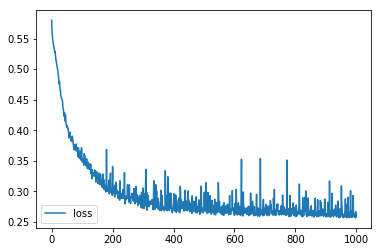

In [19]:
plt.plot(history.history['loss'])
plt.legend(['loss'], loc='lower left')
plt.show()

In [8]:
LFE_MLP_net = keras.Sequential([
            layers.Dense(500, activation='relu', input_shape=(200,)),
            layers.Dense(500, activation='relu'),
            layers.Dense(1, activation='sigmoid')
                ])
LFE_MLP_net.compile(optimizer=keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
LFE_MLP_net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 501       
Total params: 351,501
Trainable params: 351,501
Non-trainable params: 0
_________________________________________________________________
